## Exploratory Data Analysis

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

amd_df = pd.read_csv("./data/AMD.csv",parse_dates=["Date"],index_col="Date")
print(amd_df.info())
print(amd_df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8843 entries, 1983-03-21 to 2018-04-16
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Adj_Close   8843 non-null   float64
 1   Adj_Volume  8843 non-null   float64
dtypes: float64(2)
memory usage: 207.3 KB
None
            Adj_Close  Adj_Volume
Date                             
1983-03-21   8.997535    510800.0
1983-03-22   8.497672    328000.0
1983-03-23   8.717612    427200.0
1983-03-24   8.780094    393200.0
1983-03-25   8.872569    210400.0


<AxesSubplot:xlabel='Date'>

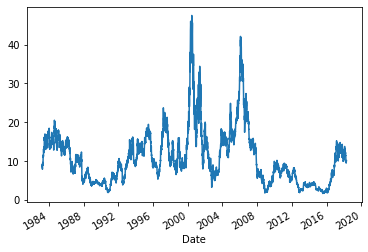

In [95]:
# Adj_Close shows (adjusted) closing stock prices 
amd_df["Adj_Close"].plot()

<AxesSubplot:ylabel='Frequency'>

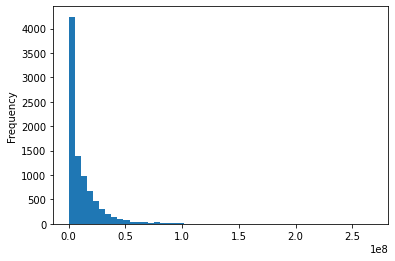

In [96]:
vol = amd_df["Adj_Volume"]
vol.plot.hist(bins=50)

We can use machine learning in many ways - we can predict the raw prices of stocks, but typically we predict percentage changes. This makes it easier to interpret the results as well as make gneeral purpose models for the data.

To get the percentage changes use the `.pct_change()` methods:

<AxesSubplot:ylabel='Frequency'>

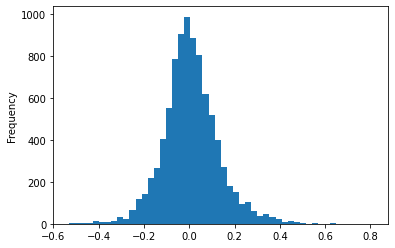

In [97]:
amd_df['10d_close_pct'] = amd_df["Adj_Close"].pct_change(10)
amd_df['10d_close_pct'].plot.hist(bins = 50)

Typically, for stocks, percentage changes are right-skewed normally distributed. **This gives "some" motivation for using something like a linear model** - the right skew is a problem (potentally needs transformation i.e. via log or square-root transformation)

Another tool is the `.shift()` - shifts the index by given amount. creates a new column with the closing price from 10days in future. We can get the price percentage change 10 days in the future:

In [98]:
amd_df['10d_future_close'] = amd_df["Adj_Close"].shift(-10)
amd_df['10d_future_close_pct'] = amd_df["10d_future_close"]

We can also look at any correlations: using the `.corr` method - however this is not very accurate/reliable. Another option is to look at the scatter plot.

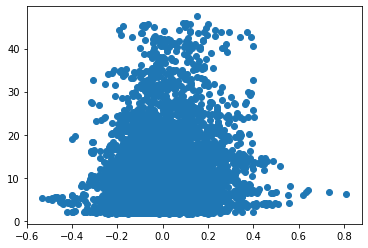

In [99]:
plt.scatter(amd_df['10d_close_pct'], amd_df["10d_future_close_pct"])
plt.show()

## Identifying features and targets

To apply machine learning methods - we need featuers and targets. In this setting, features are the inputs we need to predict future price changes - in this case this is the 10-day price change and volume. The targets are the future price changes -- since this is what we want to predict.

Other usefull features to incorporate are historical data - e.g. the moving average. The moving average is useful as it allows us to concentrate past data into a single point.

Another indicated that is useful is the relative strength index, or RSI. RSI clos to - means price is due to rebound from recent lows, RSI close to 100 may mean prices of the stock is due to decline.

The eq for RSI is :

$$ 100-\frac{100}{1+\text{RS}}$$

here, RS - relative strength is given by 

$$\text{RS} = \frac{\text{Average gain over n periods}}{\text{Average loss over n periods}}$$

is the average gain of price increases divided by the average loss of price decreases during the time prediod, $n$.

In [100]:
import talib


# Must provide numpy arrays not pandas series / df
amd_df['ma200']= talib.SMA(amd_df['Adj_Close'].values, timeperiod = 200)
amd_df['rsi200'] = talib.RSI(amd_df['Adj_Close'].values, timeperiod = 200)

#Drop all na values
amd_df = amd_df.dropna()

# Features:

feature_names = ['10d_close_pct', 'ma200', 'rsi200']
features = amd_df[feature_names]
targets = amd_df['10d_future_close_pct']

feature_target_df = amd_df[feature_names + ['10d_future_close_pct']]

## Linear modelling

 We want to split data into train and test sets - but can't use sklearns `train_test_split` as it randomly shuffles the train test data. In this context, we want to use earler (in terms of date) as the training data and the more recent prices as the test set.

In [101]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm


# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * targets.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(8633, 4) (7338, 4) (1295, 4)


In [102]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                             
Dep. Variable:     10d_future_close_pct   R-squared:                       0.837
Model:                              OLS   Adj. R-squared:                  0.837
Method:                   Least Squares   F-statistic:                 1.256e+04
Date:                  Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                          15:36:15   Log-Likelihood:                -18327.
No. Observations:                  7338   AIC:                         3.666e+04
Df Residuals:                      7334   BIC:                         3.669e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -50.4603  

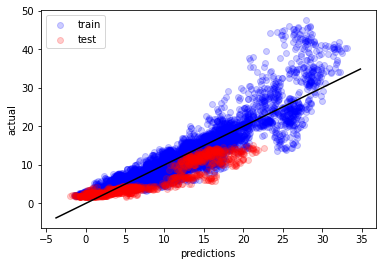

In [103]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

## Enginering Features

Something else to conisder here is the effects feature interactions. Feature interactions occurs when effects of features are combined. E.g. multipling the 14-day moving average and RSI togeter, the resulting correlation may be stronger than the individual features - The linear model above is a little limited as we must explicitly add feature interactions, whereas other models may be able to learn non-linear releationships between the features and targets. For example these include random forests, gradient boosting and NN.

More complex models allow us to engineer more features (why?) - this may improve predictive performance. The volume data will be added as a new feature. Although the volume is essentially uncorrelated to movements price, the combinations of volume and other features may add some predictive power. 

In [106]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
amd_df["Adj_Volume_1d_change"] = amd_df['Adj_Volume'].pct_change()
amd_df["Adj_Volume_1d_change_SMA"] = talib.SMA(amd_df["Adj_Volume_1d_change"].values,
                        timeperiod=5)
# print(amd_df.head())

<Figure size 432x288 with 0 Axes>

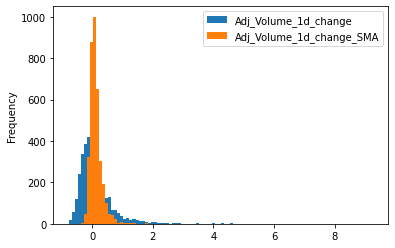

In [107]:
# Plot histogram of volume % change data
plt.clf()
# plt.xlim(-0.5, 1)
amd_df[new_features].iloc[5000:].plot(kind='hist', sharex=False, bins=100)
plt.show()

We can also engineer datetime features to add even more information for our non-linear models. Here we will focus on the day of the week.

Note we can also get more long range features like years and months since this data goes back really far.

In [108]:
# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(amd_df.index.dayofweek,
                              prefix="weekday",
                              drop_first=True)

# Set the index as the original dataframe index for merging
days_of_week.index = amd_df.index

# Join the dataframe with the days of week dataframe
amd_df = pd.concat([amd_df, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
amd_df.dropna(inplace=True)  # drop missing values in-place
print(amd_df.head())

            Adj_Close  Adj_Volume  10d_close_pct  10d_future_close  \
Date                                                                 
1984-01-11  17.810121    531400.0       0.075460         16.620446   
1984-01-12  18.369967   1699400.0       0.122137         15.620720   
1984-01-13  17.995070   1534800.0       0.070473         15.055875   
1984-01-16  17.995070    349800.0       0.070473         14.496028   
1984-01-17  18.369967    317200.0       0.088889         14.371063   

            10d_future_close_pct      ma200     rsi200  Adj_Volume_1d_change  \
Date                                                                           
1984-01-11             16.620446  14.208132  56.057199             -0.305722   
1984-01-12             15.620720  14.257806  56.403079              2.197968   
1984-01-13             15.055875  14.304044  56.105867             -0.096858   
1984-01-16             14.496028  14.352155  56.105867             -0.772088   
1984-01-17             14.371

It is important to establish the correlations between our new features and the target (i.e. `10d_future_close_pct`) to see how strongly the are related.

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, 'Adj_Volume_1d_change'),
  Text(1.5, 0, 'Adj_Volume_1d_change_SMA'),
  Text(2.5, 0, 'weekday_1'),
  Text(3.5, 0, 'weekday_2'),
  Text(4.5, 0, 'weekday_3'),
  Text(5.5, 0, 'weekday_4'),
  Text(6.5, 0, '10d_future_close_pct')])

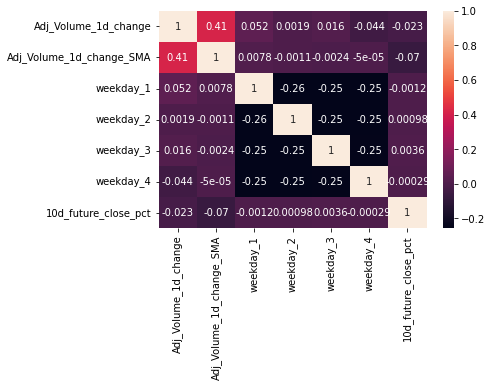

In [124]:
import seaborn as sns
# Add the weekday labels to the new_features list
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
new_features.extend(["weekday_" + str(i) for i in range(1, 5)])

# Plot the correlations between the new features and the targets
sns.heatmap(amd_df[new_features + ['10d_future_close_pct']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
# plt.tight_layout()
# plt.show()

## Regression trees

In [160]:
# Add a constant to the features
amd_df.dropna(inplace=True)  # drop missing values in-place
features = amd_df[feature_names]
targets = amd_df['10d_future_close_pct']
# linear_features = sm.add_constant(features)
# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * targets.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]
print(features.shape, train_features.shape, test_features.shape)
print(train_targets.shape, test_targets.shape, test_features.shape)

(8628, 11) (7333, 11) (1295, 11)
(7333,) (1295,) (1295, 11)


In [162]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

decision_tree = DecisionTreeRegressor(max_depth = 5)
decision_tree.fit(train_features,train_targets)

train_predict = decision_tree.predict(train_features)
# accuracy_score(train_predict,train_targets)

print(decision_tree.score(train_features,train_targets))
print(decision_tree.score(test_features,test_targets))

0.9276312276886262
0.7130596600081904


In [165]:
# from sklearn import tree
# print(tree.export_text(decision_tree))

Of course, it is important to optimize the machine learning model - an important hyperparamter here is `max_depth`. 

Here we just do a very simple search.

In [166]:
# Loop through a few different max depths and check the performance
for d in [3,5,10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth=d)
    decision_tree.fit(train_features, train_targets)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features,train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')


max_depth= 3
0.819917971770054
0.7066016283250715 

max_depth= 5
0.9276312276886262
0.7130596600081903 

max_depth= 10
0.9833965349152441
0.695828127581289 



To visualise resuluts:

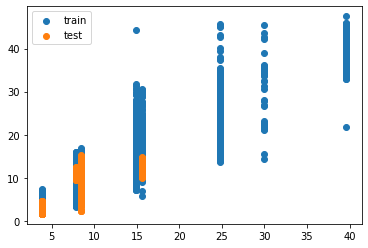

In [169]:
# Use the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth = 3)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# Scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets,label='test')
plt.legend()
plt.show()

## Random Forests

Decision trees can suffer from high variance - one way to address this is to use ensemble learning methods such as random forests. An important advantage of random forest over bagging is that it decorrelates the trees - here in addition to using boostrap samples - each independent tree is built using a random sample of a subset of the predictors.

In [171]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor()
random_forest.fit(train_features,train_targets)

0.9964519340305501


In [174]:
print(random_forest.score(train_features,train_targets))
print(random_forest.score(test_features,test_targets))

0.9964519340305501
0.7469277255694566


In [ ]:
Choosing the wrong hyperparameters can give really bad scores

In [181]:
random_forest = RandomForestRegressor(n_estimators=10,
                                     max_depth = 3,
                                     max_features=3,
                                     random_state=42)
random_forest.fit(train_features,train_targets)

print(random_forest.score(train_features,train_targets))
print(random_forest.score(test_features,test_targets))

0.6096407018043957
-0.709623106638388


Here we are using a grid search - `GridSearchCV` is also a possibility.

In [187]:
from sklearn.model_selection import ParameterGrid

grid = {'n_estimators':[200],
       'max_depth':[3,5],
       'max_features':[4,8]}

from pprint import pprint
pprint(list(ParameterGrid(grid)))

test_scores = []

# loop through the parameter grid, set hyperparameters, save the scores

for g in ParameterGrid(grid):
    random_forest.set_params(**g)
    random_forest.fit(train_features,train_targets)
    test_scores.append(random_forest.score(test_features,test_targets))

# find best hyperparameters from the test score and print 

best_idx = np.argmax(test_scores)
print(test_scores[best_idx])
print(ParameterGrid(grid)[best_idx])

[{'max_depth': 3, 'max_features': 4, 'n_estimators': 200},
 {'max_depth': 3, 'max_features': 8, 'n_estimators': 200},
 {'max_depth': 5, 'max_features': 4, 'n_estimators': 200},
 {'max_depth': 5, 'max_features': 8, 'n_estimators': 200}]
0.7631357808071015
{'n_estimators': 200, 'max_features': 8, 'max_depth': 5}


Interestingly you get a better test score when doing a "manual" tuning like this - rather than just using the `RandomForestRegressor()` on its own.

In [194]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=5, max_features=8, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

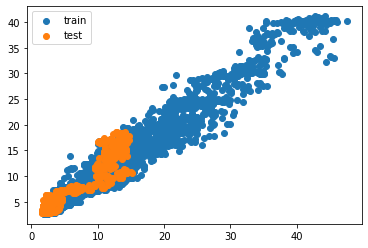

In [196]:
# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets,test_predictions, label='test')
plt.legend()
plt.show()

Tree-based methods allow us to get "feature importance". These are scores representing how much each feature contributes to a prediction. For regression this is how much each feature can help reduce the variance with it splits the data. 

This is stored in a property called `feature_importance`.

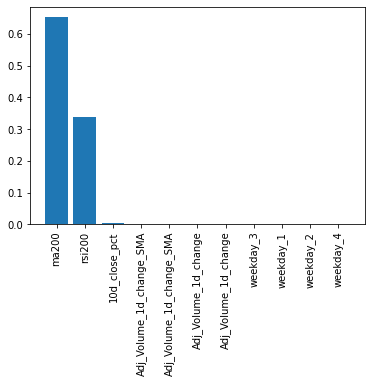

In [198]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

Looking at the graph above we can see that the days-of-the-week variables are very weak predictors, so they don't reduce the variance much. This means that their feature importance is low, so we may wany to discard those features.

Other features like the 200-day simple moving average, are better at reducing the variance in the data - so have a higher score.

## Gradient Boost

In [ ]:
Boosted models have the potential to work much better, but are also much more difficult to use and interpret.

In [201]:
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features,train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.8288528661458865
0.12078587297552879
